In [ ]:
import pandas as pd
import re
from transformers import XLMRobertaTokenizer

# Ensure the tokenizer is available after installing sentencepiece
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Load the dataset
df = pd.read_csv(
    "/content/new_50k_english.csv"
)

In [ ]:
# Preprocessing: Remove mentions and URLs
df['tweet='] = df['tweet'].apply(lambda x: re.sub(r'@\w+|http\S+', '', x))

In [ ]:
# Remove special characters and extra spaces
df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'[^A-Za-z\s]', '', x))

In [ ]:
# Convert to lowercase
df['tweet'] = df['tweet'].str.lower()

In [ ]:
# Remove duplicates and empty tweets
df = df.drop_duplicates(subset='tweet')
df = df[df['tweet'].str.strip() != '']

In [ ]:
# Encode sentiment labels (0: Negative, 1: Neutral, 2: Positive)
label_mapping = {0:0,4:1}
df['label'] = df['label'].map(label_mapping)

In [ ]:
print("Unique labels in the dataset:", df['label'].unique())


Unique labels in the dataset: [0 1]


In [ ]:
# Tokenize tweets
def tokenize_tweet(text):
    return tokenizer(text, padding='max_length', truncation=True, max_length=64, return_tensors="pt")

df['tokenized'] = df['tweet'].apply(tokenize_tweet)

In [ ]:
import nltk
from nltk.corpus import stopwords

# Download stopwords if you haven't already
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Remove stop words
df['tweet'] = df['tweet'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

In [ ]:
import nltk

# Download the WordNet resource
nltk.download('wordnet')

# Lemmatization (optional)
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
df['tweet'] = df['tweet'].apply(lambda x: ' '.join(lemmatizer.lemmatize(word) for word in x.split()))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class TweetDataset(Dataset):
    def __init__(self, tweets, labels):
        self.tweets = tweets
        self.labels = labels

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, idx):
        return {
            'input_ids': self.tweets[idx]['input_ids'].squeeze(),  # Remove extra dimensions
            'attention_mask': self.tweets[idx]['attention_mask'].squeeze(),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)  # Convert label to tensor
        }

# Split your DataFrame into training and validation sets
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Create datasets
train_dataset = TweetDataset(train_df['tokenized'].tolist(), train_df['label'].tolist())
val_dataset = TweetDataset(val_df['tokenized'].tolist(), val_df['label'].tolist())

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [ ]:
from transformers import XLMRobertaForSequenceClassification

# Load the XLM-R model for sequence classification
model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels=2)  # 3 labels for sentiment


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Inspect a batch to see the contents
for batch in train_loader:
    print(batch)
    break


{'input_ids': tensor([[     0, 147115,   3871,  ...,      1,      1,      1],
        [     0, 152725,     17,  ...,      1,      1,      1],
        [     0,   6863,    136,  ...,      1,      1,      1],
        ...,
        [     0,    442,  23409,  ...,      1,      1,      1],
        [     0,    759,  67155,  ...,      1,      1,      1],
        [     0,   2121,    321,  ...,      1,      1,      1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'label': tensor([0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
        0, 1, 1, 0, 0, 1, 0, 1])}


In [ ]:
from sklearn.model_selection import train_test_split
from transformers import AdamW, get_scheduler
from sklearn.metrics import accuracy_score, classification_report

# Prepare for training
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Define optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 5
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# Training and Evaluation Loop
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    correct_train = 0

    for batch in train_loader:
        # Move inputs and labels to the same device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Backward pass
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        total_train_loss += loss.item()

        # Move predictions and labels to CPU for comparison
        preds = torch.argmax(outputs.logits, dim=-1).cpu()
        correct_train += (preds == labels.cpu()).sum().item()

    # Calculate training metrics
    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train / len(train_dataset)

    # Validation Loop
    model.eval()
    total_val_loss = 0
    correct_val = 0

    with torch.no_grad():
        for batch in val_loader:
            # Move inputs and labels to the same device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()

            # Move predictions and labels to CPU for comparison
            preds = torch.argmax(outputs.logits, dim=-1).cpu()
            correct_val += (preds == labels.cpu()).sum().item()

    # Calculate validation metrics
    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct_val / len(val_dataset)

    # Print metrics for the epoch
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Training loss: {avg_train_loss:.4f}, Training accuracy: {train_accuracy:.4f}")
    print(f"Validation loss: {avg_val_loss:.4f}, Validation accuracy: {val_accuracy:.4f}\n")


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5
Training loss: 0.6121, Training accuracy: 0.6625
Validation loss: 0.4662, Validation accuracy: 0.7897

Epoch 2/5
Training loss: 0.4702, Training accuracy: 0.7900
Validation loss: 0.4285, Validation accuracy: 0.8044

Epoch 3/5
Training loss: 0.3933, Training accuracy: 0.8327
Validation loss: 0.4306, Validation accuracy: 0.8111

Epoch 4/5
Training loss: 0.3332, Training accuracy: 0.8614
Validation loss: 0.4498, Validation accuracy: 0.8107

Epoch 5/5
Training loss: 0.2939, Training accuracy: 0.8880
Validation loss: 0.4991, Validation accuracy: 0.8094



Validation Accuracy: 0.8094
Confusion Matrix:


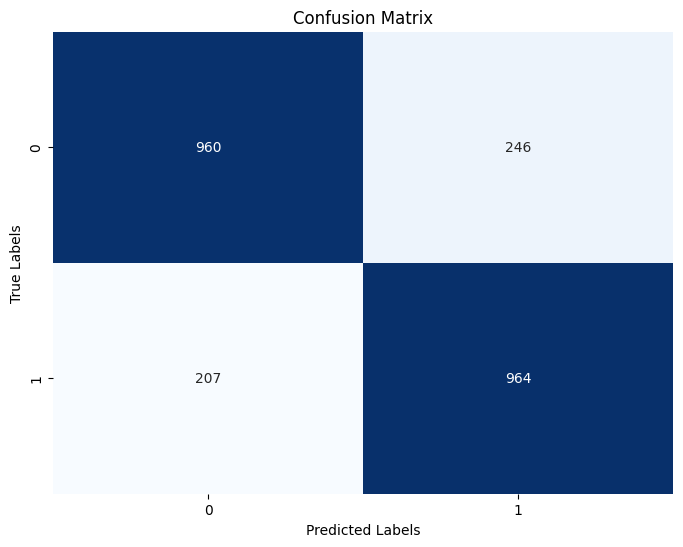

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Predictions on validation set and confusion matrix
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Get predictions
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=-1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
val_accuracy = accuracy_score(all_labels, all_preds)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
!pip install gradio

In [ ]:
import gradio as gr

# Define a function to make predictions
def classify_tweet(tweet):
    # Preprocess the tweet
    tweet = re.sub(r'@\w+|http\S+', '', tweet)  # Remove mentions and URLs
    tweet = re.sub(r'[^A-Za-z\s]', '', tweet)  # Remove special characters
    tweet = tweet.lower()  # Convert to lowercase
    tweet = ' '.join(word for word in tweet.split() if word not in stop_words)  # Remove stopwords
    tweet = ' '.join(lemmatizer.lemmatize(word) for word in tweet.split())  # Lemmatization

    # Tokenize the tweet
    tokenized_tweet = tokenizer(tweet, padding='max_length', truncation=True, max_length=64, return_tensors="pt")
    input_ids = tokenized_tweet['input_ids'].to(device)
    attention_mask = tokenized_tweet['attention_mask'].to(device)

    # Make prediction
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=-1)

    # Map the prediction back to the sentiment label
    sentiment_map = {0: "Negative", 1: "Positive"}
    return sentiment_map[preds.item()]

# Create Gradio interface
interface = gr.Interface(fn=classify_tweet,
                         inputs="text",
                         outputs="label",
                         title="Sentiment Classifier",
                         description="Classify tweets as Positive or Negative.")

# Launch the interface
interface.launch()


In [ ]:
# Save the trained model
model_save_path = "xlm_roberta_sentiment_model.pth"
torch.save(model.state_dict(), model_save_path)

# Save the tokenizer
tokenizer_save_path = "xlm_roberta_tokenizer"
tokenizer.save_pretrained(tokenizer_save_path)


('xlm_roberta_tokenizer/tokenizer_config.json',
 'xlm_roberta_tokenizer/special_tokens_map.json',
 'xlm_roberta_tokenizer/sentencepiece.bpe.model',
 'xlm_roberta_tokenizer/added_tokens.json')